<img src="https://miro.medium.com/max/7222/1*4bvp-cTFw67xwHxDzZ5kOw.jpeg" alt="Overstory" width="200"/>

# Senior Data Scientist Take-home test

Please save a copy of this notebook or download it as ipynb before starting. When you're done, zip you final notebook and any other relevant files and upload it using the link provided to you in an email.

---


>**Notice**:
>Please note that google collab is not the most relastic and easy way to work with large satellite datasets. Please note that all data is available over s3 which means that you can spin up your own aws or google cloud instances to work with.
>
>This can especially be helpful if two libraries that can cause some issues `gdal` and `rasterio` are giving you errors when loading the data. If restarting the kernel doesnt help, be creative: you don't _have_  to use google colab for the assignment (but preferably use a Jupyter notebook).

---

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Cloud Cover Segmentation

We'd like you to segment out clouds from a satellite image. This is an important aspect of working with satellite data, as cloud-obscured pixels should either be filtered out, or be made aware of through a cloud-mask "band" (in remote sensing, channels are called bands. There are usually more than the usual 3 for RGB in computer vision, e.g. R, G, B, near infrared, etc.)

Please use only the optical and reflectance bands for this exercise (we know that some images, depending on where you acquire them, could include analytical bands such as a ready cloud mask, please don't use those for the exercise).

You can use any method you like to complete the task (write an algorithm or train a model), however **please don't use Google Earth Engine for your solution**. We are happy for you to train an ML model, but an ML model is definitely not a requirement.

The dataset we have provided for you consist of satellite tiles from the Sentinel-2 constellation. (see https://sentinel.esa.int/web/sentinel/missions/sentinel-2)

![global grid](https://i.imgur.com/6X1oApw.png)

Tiles (or granules) have names such as "58KFC", which are large 100 x 100 km images of the earth. For sentinel-2 these come at a resolution of 10m, so an image of about 10980x10980 pixels. A bit larger than your standard computer vision image :D

Usually such satellite "products" have to be preprocessed in various ways (atmospheric correction, and all kinds of other denoising operations). For the purpose of this exercise we will provide you with ready to use tiles.

<img src="https://i.imgur.com/FyR0r87.jpg" alt="processing" width="500"/>

(before and after processing)

# The data

Sentinel-2 (the data we're using) has 11 bands/channels! For ease here's a snippet that lets you just load the rgb, and near infrared channels. For an overview of all channels see https://en.wikipedia.org/wiki/Sentinel-2.

Since a single image is about 10980 x 10980 pixels, you may want to cut this up into smaller images, before usgin them. We'll leave this for you to figure out :)

You will use rasterio, as a library to load a multi band tif file. We have made a couple of tiles available on our public s3.

For example there is the file `Sentinel2L2A_sen2cor_58KFC_20181021_clouds=1.2%_area=100%.tif` which means that its a Sentinel product `2L2A`, a particular enrichment level we don't care much about for the moment. It has been preprocessed using `sen2cor`: also not something we care about right now. The tile_id, _is_ something we care about, `58KFC` in this case (No not for Kentucky Fried Chicken), and then the date `2018-20-21`  which is what we care for when there are multiple tiles with the same tile_id, as an image of the earth is unique by `location` and by `time`. So the tile_id + the date will be the unique identifier. Further we can see that a rough estimation of the percent of clouds is 1.2% and that the Sentinel2 satellite has managed to take an image of the whole area (if there are missing values, they tend to be set to a value of `255` for `no_data`)

Similarly you can find another tif file called `cloud_mask_58KFC_20181021_clouds=5%.tif`. That's the automatically created cloud mask. Here we can see that the `tile_id` is the same: `58KFC`, and the date the same as the above input tile as well: `2018-20-21`. The clouds as estimated by an out of the box cloud detection classifier (which should be easy to outperform), it estimates that 5% of the image are actually clouds (versus what the Sentinel2 - similarly not very good - cloud detection model estimates 1.2%).

So there you have it:
- X: `Sentinel2L2A_sen2cor_58KFC_20181021_clouds=1.2%_area=100%.tif`
- Y: `cloud_mask_58KFC_20181021_clouds=5%.tif`

To save space and memory the tiles are also available as RGB only 3-bands (500mb instead of 2.5GB tif files):
- X: `Sentinel2L2A_sen2cor_58KFC_20181021_clouds=1.2%_area=100%_RGB.tif`
- Y: stays the same

example pair stored at a public s3 bucket:
![s3-ex](https://20tree-public.s3-eu-west-1.amazonaws.com/candidates/cloudmask/s3-ex.png)

We expect you to figure out the specifics of the data by yourself, but here's a bit more info about the cloud mask which we derived from the [theia-sentinel product](https://labo.obs-mip.fr/multitemp/sentinel-2/theias-sentinel-2-l2a-product-format/#English):

<img src="https://20tree-public.s3-eu-west-1.amazonaws.com/candidates/cloudmask/theia_cloud_mask.png" alt="theia_cm" width="400"/>


Example pairs of tile and mask:
![ex1](https://20tree-public.s3-eu-west-1.amazonaws.com/candidates/cloudmask/ex1.png)
![ex2](https://20tree-public.s3-eu-west-1.amazonaws.com/candidates/cloudmask/ex2.png)
![ex3](https://20tree-public.s3-eu-west-1.amazonaws.com/candidates/cloudmask/ex3.png)


To make things easier we've hosted 3 text files with links to all the data, allowing you to more easily download all files:
- rgb_tiles.txt: https://20tree-public.s3-eu-west-1.amazonaws.com/candidates/cloudmask/rgb_tiles.txt
- tif_tiles.txt: https://20tree-public.s3-eu-west-1.amazonaws.com/candidates/cloudmask/tif_tiles.txt
- masks.txt: https://20tree-public.s3-eu-west-1.amazonaws.com/candidates/cloudmask/masks.txt

In [2]:
!wget --content-disposition --trust-server-names -i https://20tree-public.s3-eu-west-1.amazonaws.com/candidates/cloudmask/masks.txt

--2022-12-20 12:15:45--  https://20tree-public.s3-eu-west-1.amazonaws.com/candidates/cloudmask/masks.txt
Resolving 20tree-public.s3-eu-west-1.amazonaws.com... 52.218.46.10, 52.218.121.154, 52.218.92.8, ...
Connecting to 20tree-public.s3-eu-west-1.amazonaws.com|52.218.46.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1378 (1.3K) [text/plain]
Saving to: 'masks.txt'

masks.txt           100%[===================>]   1.35K  --.-KB/s    in 0s      

2022-12-20 12:15:45 (57.1 MB/s) - 'masks.txt' saved [1378/1378]

--2022-12-20 12:15:45--  https://20tree-public.s3-eu-west-1.amazonaws.com/candidates/cloudmask/cloud_mask_18TUR_20180812_clouds%3D24%25.tif
Reusing existing connection to 20tree-public.s3-eu-west-1.amazonaws.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 1830454 (1.7M) [image/tiff]
Saving to: 'cloud_mask_18TUR_20180812_clouds=24%.tif'

cloud_mask_18TUR_20 100%[===================>]   1.75M  6.01MB/s    in 0.3s    

2022-12-20 12:15:46 (

In [3]:
!ls

Takehome_Noelia.ipynb
Untitled.ipynb
cloud_mask_18TUR_20180812_clouds=24%.tif
cloud_mask_21NYC_20171206_clouds=84%.tif
cloud_mask_28PDU_20171002_clouds=70%.tif
cloud_mask_28PDU_20180609_clouds=16%.tif
cloud_mask_29RPP_20180206_clouds=44%.tif
cloud_mask_30TXR_20190618_clouds=35%.tif
cloud_mask_31PDM_20190911_clouds=79%.tif
cloud_mask_31TCG_20171030_clouds=40%.tif
cloud_mask_32SNC_20181202_clouds=21%.tif
cloud_mask_33TVF_20191104_clouds=84%.tif
cloud_mask_49RFN_20190806_clouds=61%.tif
cloud_mask_58KFC_20181021_clouds=5%.tif
masks.txt


In [4]:
!ls -lah *.tif

-rw-r--r--  1 noeliaotero  staff   1.7M Apr 16  2020 cloud_mask_18TUR_20180812_clouds=24%.tif
-rw-r--r--  1 noeliaotero  staff   2.5M Apr 16  2020 cloud_mask_21NYC_20171206_clouds=84%.tif
-rw-r--r--  1 noeliaotero  staff   3.4M Apr 16  2020 cloud_mask_28PDU_20171002_clouds=70%.tif
-rw-r--r--  1 noeliaotero  staff   973K Apr 16  2020 cloud_mask_28PDU_20180609_clouds=16%.tif
-rw-r--r--  1 noeliaotero  staff   1.9M Apr 16  2020 cloud_mask_29RPP_20180206_clouds=44%.tif
-rw-r--r--  1 noeliaotero  staff   1.9M Apr 16  2020 cloud_mask_30TXR_20190618_clouds=35%.tif
-rw-r--r--  1 noeliaotero  staff   1.5M Apr 16  2020 cloud_mask_31PDM_20190911_clouds=79%.tif
-rw-r--r--  1 noeliaotero  staff   1.4M Apr 16  2020 cloud_mask_31TCG_20171030_clouds=40%.tif
-rw-r--r--  1 noeliaotero  staff   1.2M Apr 16  2020 cloud_mask_32SNC_20181202_clouds=21%.tif
-rw-r--r--  1 noeliaotero  staff   2.6M Apr 16  2020 cloud_mask_33TVF_20191104_clouds=84%.tif
-rw-r--r--  1 noeliaotero  staff   2.8M Apr 16  2020 cloud_m

You can download the s3 data to use here, but since the files are pretty large you can also upload the dataset to your Google Drive where you can use it by mounting it like here:

In [5]:
from google.colab import drive
drive.mount('/gdrive')

ModuleNotFoundError: No module named 'google'

Since all of this might be a bit new and we dont expect you to spend more than half a day (or a couple of days part-time), we will provide some helper functions for using geotif data through rasterio:

In [ ]:
!pip install rasterio

In [1]:
from matplotlib import pyplot as plt
import os
import rasterio
import numpy as np

def _ensure_opened(ds):
    "Ensure that `ds` is an opened Rasterio dataset and not a str/pathlike object."
    return ds if type(ds) == rasterio.io.DatasetReader else rasterio.open(str(ds), "r")


def read_crop(ds, crop, bands=None, pad=False):
    """
    Read rasterio `crop` for the given `bands`..
    Args:
        ds: Rasterio dataset.
        crop: Tuple or list containing the area to be cropped (px, py, w, h).
        bands: List of `bands` to read from the dataset.
    Returns:
        A numpy array containing the read image `crop` (bands * h * w).
    """
    ds = _ensure_opened(ds)
    if pad: raise ValueError('padding not implemented yet.')
    if bands is None:
        bands = [i for i in range(1, ds.count+1)]

    #assert len(bands) <= ds.count, "`bands` cannot contain more bands than the number of bands in the dataset."
    #assert max(bands) <= ds.count, "The maximum value in `bands` should be smaller or equal to the band count."
    window = None
    if crop is not None:
        assert len(crop) == 4, "`crop` should be a tuple or list of shape (px, py, w, h)."
        px, py, w, h = crop
        w = ds.width - px if (px + w) > ds.width else w
        h = ds.height - py if (py + h) > ds.height else h
        assert (px + w) <= ds.width, "The crop (px + w) is larger than the dataset width."
        assert (py + h) <= ds.height, "The crop (py + h) is larger than the dataset height."
        window = rasterio.windows.Window(px, py, w, h)
    meta = ds.meta
    meta.update(count=len(bands))
    if crop is not None:
        meta.update({
        'height': window.height,- make the aoi more smooth so data is easier correctly downloaded
        'width': window.width,
        'transform': rasterio.windows.transform(window, ds.transform)})
    return ds.read(bands, window=window), meta

def plot_rgb(img, clip_percentile=(2, 98), clip_values=None, bands=[3, 2, 1], figsize=(20, 20), nodata=None, figtitle=None, crop=None, ax=None):
    """
    Plot clipped (and optionally cropped) RGB image.
    Args:
        img: Path to image, rasterio dataset or numpy array of shape (bands, height, width).
        clip_percentile: (min percentile, max percentile) to use for clippping.
        clip_values: (min value, max value) to use for clipping (if set clip_percentile is ignored).
        bands: Bands to use as RGB values (starting at 1).
        figsize: Size of the matplotlib figure.
        figtitle: Title to use for the figure (if None and img is a path we will use the image filename).
        crop: Window to use to crop the image (px, py, w, h).
        ax: If not None, use this Matplotlib axis for plotting.
    Returns:
        A matplotlib figure.
    """
    meta = None
    if isinstance(img, str):
        assert os.path.exists(img), "{} does not exist!".format(img)
        figtitle = os.path.basename(img) if figtitle is None else figtitle
        img = rasterio.open(img)
        img, meta = read_crop(img, crop, bands)
    elif isinstance(img, rasterio.io.DatasetReader):
        img, meta = read_crop(img, crop, bands)
    elif isinstance(img, np.ndarray):
        assert len(img.shape) <= 3, "Array should have no more than 3 dimensions."
        if len(img.shape) == 2:
            img = img[np.newaxis, :, :]
        elif img.shape[0] > 3:
            img = img[np.array(bands) - 1, :, :]
        if crop is not None:
            img = img[:, py:py+h, px:px+w]
    else:
        raise ValueError("img should be str, rasterio dataset or numpy array. (got {})".format(type(img)))
    img = img.astype(float)
    nodata = nodata if nodata is not None else (meta['nodata'] if meta is not None else None)
    if nodata is not None:
        img[img == nodata] = np.nan
    if clip_values is not None:
        assert len(clip_values) == 2, "Clip values should have the shape (min value, max value)"
        assert clip_values[0] < clip_values[1], "clip_values[0] should be smaller than clip_values[1]"
    elif clip_percentile is not None:
        assert len(clip_percentile) == 2, "Clip_percentile should have the shape (min percentile, max percentile)"
        assert clip_percentile[0] < clip_percentile[1], "clip_percentile[0] should be smaller than clip_percentile[1]"
        clip_values = None if clip_percentile == (0, 100) else [np.nanpercentile(img, clip_percentile[i]) for i in range(2)]
    if clip_values is not None:
        img[~np.isnan(img)] = np.clip(img[~np.isnan(img)], *clip_values)
    clip_values = (np.nanmin(img), np.nanmax(img)) if clip_values is None else clip_values
    img[~np.isnan(img)] = (img[~np.isnan(img)] - clip_values[0])/(clip_values[1] - clip_values[0])
    if img.shape[0] <= 3:
        img = np.transpose(img, (1, 2, 0))
    alpha = np.all(~np.isnan(img), axis=2)[:,:,np.newaxis].astype(float)
    img = np.concatenate((img, alpha), axis=2)

    if not ax:
        figure, ax = plt.subplots(1, 1, figsize=figsize)
        ax.set_title(figtitle) if figtitle is not None else None
        ax.imshow(img)
        plt.close()
        return figure
    else:
        ax.imshow(img)

SyntaxError: invalid syntax (<ipython-input-1-d9dd5e7ae028>, line 41)

Time to check the data for real:

In [ ]:
X = ["Sentinel2L2A_sen2cor_58KFC_20181021_clouds=1.2%_area=100%.tif"]
y = ["cloud_mask_58KFC_20181021_clouds=5%.tif"]

Let's plot the full tile, but rescaled to a managable size with our plot_rgb() function, as well as choosing with bands to visualize as rgb (1-3 in this example), as a matplotlib figure, so we dont blow things up:

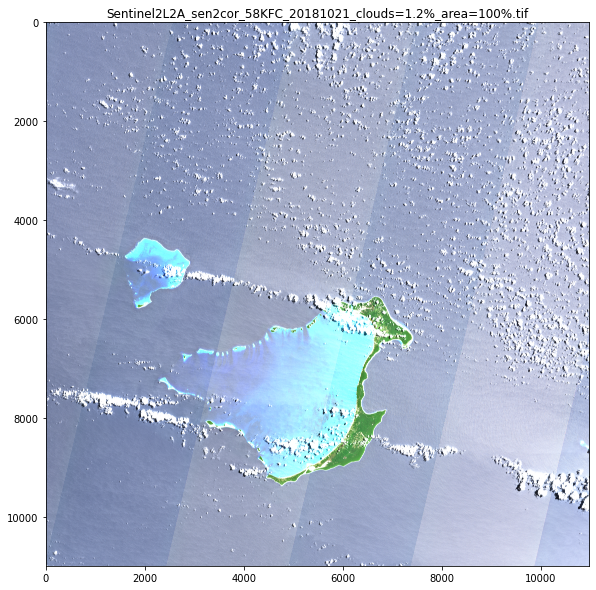

In [ ]:
plot_rgb(X[0], clip_values=(0,1000), bands=[3,2,1], figsize=(10, 10))

same for the cloud mask that only has 1 band/channel, so we put band 1 for r,g _and_ b :) :

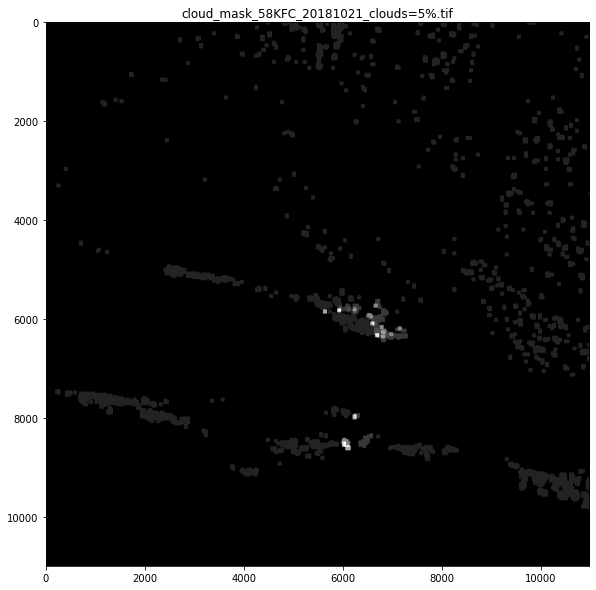

In [ ]:
plot_rgb(y[0], clip_values=(0,50), bands=[1,1,1], figsize=(10, 10))

To make things a little bit easier, as rasterio specifics might be unfamiliar, heres an example of that reads a particular patch of a larger window:


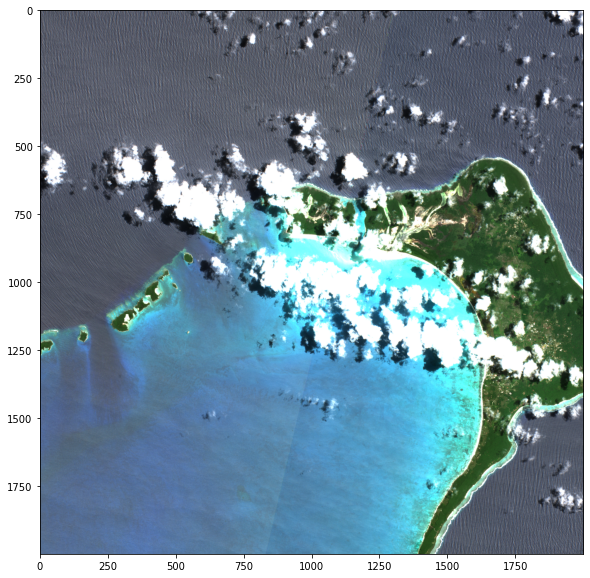

In [ ]:
bands=[3,2,1]
ds = _ensure_opened(X[0])
(px, py, w, h) = 5000,5000,2000,2000 #left, top, tilesize, tilesize
image, meta = read_crop(ds, (px, py, w, h), bands=bands)

#write it away as a file
with rasterio.open("testX.tif", 'w', **meta) as dst:
    dst.write(image)

#show it
fig = plt.figure(figsize=(10,10))
img = rasterio.open("testX.tif").read()
img = np.clip(img, 0, 2000)/2000.0
plt.imshow(np.transpose(img, (1,2,0)))

In [ ]:
image.shape

(3, 2000, 2000)

3 channels/bands, reading the actual tif directly through rasterio will give us the full data to work with:

In [ ]:
im = rasterio.open(X[0]).read(8) #here we read band 8, which you can see in the sentinel product documentation is the NIR band
im.shape

(10980, 10980)

In [ ]:
img = im[:1000,:1000].reshape((1,1000,1000)) #lets visualize a 1000px x 1000px window

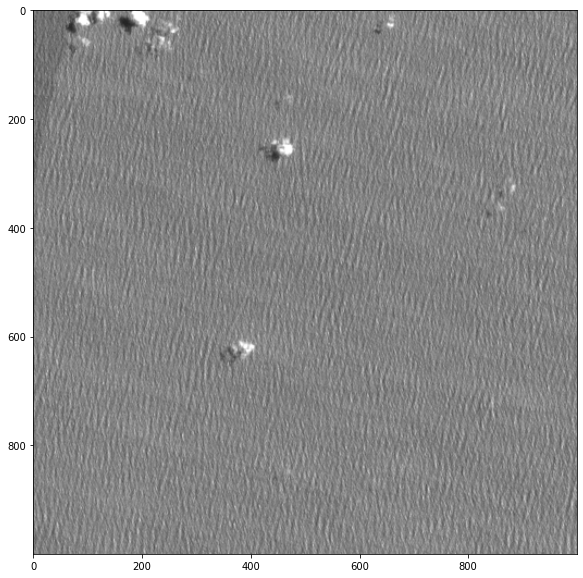

In [ ]:
fig = plt.figure(figsize=(10,10))
img = np.clip(img, 0, 1000)/1000.0
plt.imshow(np.transpose(np.repeat(img, [3], axis=0),(1,2,0))) #simple hack to show 1 channel as 3, we just copy it 3 times :)

Let's visualize the cloud mask:

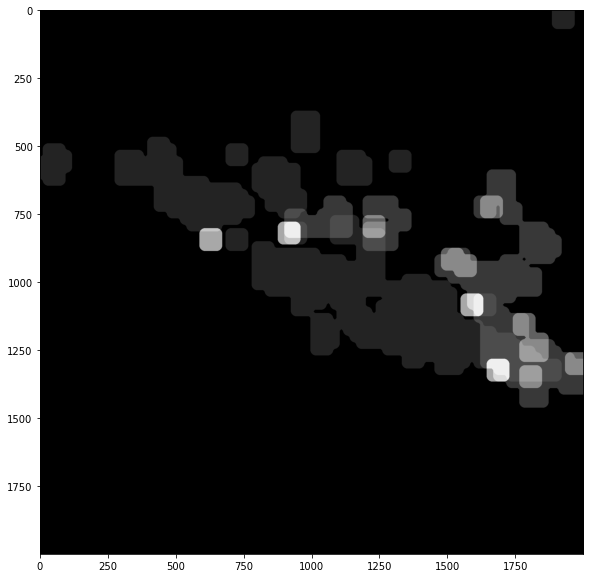

In [ ]:
bands=[1] # only 1 channel/band
ds = _ensure_opened(y[0])
(px, py, w, h) = 5000,5000,2000,2000 #left, top, right-left, bottom-top
image, meta = read_crop(ds, (px, py, w, h), bands=bands)

#write it away as a file
with rasterio.open("testY.tif", 'w', **meta) as dst:
    dst.write(image)

#show it
fig = plt.figure(figsize=(10,10))
img = rasterio.open("testY.tif").read()
img = np.clip(img, 0, 50)/50.0 # we put max to 50 here but this is image specific
plt.imshow(np.transpose(np.repeat(img, [3], axis=0),(1,2,0))) #simple hack to show 1 channel as 3, we just copy it 3 times :)

We can also check all unique values in the cloud mask, remembering that particular bits are used for particular values (go back to the theia sentinel product image to see their meaning)

In [ ]:
image.shape

(1, 2000, 2000)

In [ ]:
np.unique(image)

array([ 0,  1,  3,  7, 11, 15, 19, 27, 31, 33, 39, 43, 47], dtype=uint8)

# What we expect from you

We want you to develop your own way of segmenting clouds from the rest of the image. We don't mind how you do it: you can use Machine Learning or you can simply use image processing techniques, we want you to rely on your experience. If you decide to solve this problem with ML, please use [PyTorch](https://pytorch.org/) (helper libraries as [fastai](https://fast.ai) are fine to use, but be sure to use [v2](https://github.com/fastai/fastai2/) in this case). 

It's less important to have an amazingly precise result than for us to be able to see how you go about solving this problem, the steps you took to make sense of the data, how you evaluate your solution's performance, and how you would improve on the performance down the line. This is the kind of problem that can be improved upon endlessly, so we are certainly not looking for a perfect solution.

When you're done zip the final notebook as well as any other supporting files we would need to see to run your code and evaluate your workings. 


# Make sure that:
- Every step is documented 
- You include some final predictions in the results
- If you used ML, include a confuisom matrix and some accuracy metric on a validation set (a tile not used for training) and a function we can easily run ourselves to load a trained model and run a predicton

## Some advice:
- If using ML, you will want to split up the larger tiles into smaller batches of much smaller pixels (64-256px) for easier and more generalizable training and you might want to use data augmentation to "synthetize" more training data
- Google Earth Engine lets you play with datasets for satellite imagery in a JavaScript playground. If satellite images are new to you, you might want to have a go here as well to see what's generally possible. https://developers.google.com/earth-engine/playground & https://code.earthengine.google.com/

## More data:
- You are allowed to add more data by downloading Sentinel tiles, or adding other cloud cover datasets.
- The tiles we have made available for you are L2A (sen2cor processed) products that will be missing some atmospheric bands that _are_ available in the L2A products. If you feel like going the extra mile you _could_ download these from https://scihub.copernicus.eu/. There's a short tutorial [here](https://www.gis-blog.com/download-sentinel-2-l2a-products/).

# Useful functions for Google Collab environment
You should be able to run this notebook at https://colab.research.google.com/. At some point when loading a large tif file it might ask you if you'd like to use a high memory instance, answer "Yes" and things will become even smoother.

In [ ]:
#if you need more memory: reset until you get P100 GPU in Colab
# runtime > restart runtime

from IPython.display import HTML
from subprocess import getoutput
s = getoutput('nvidia-smi')
if 'K80' in s:
  gpu = 'K80'
elif 'T4' in s:
  gpu = 'T4'
elif 'P100' in s:
  gpu = 'P100'
display(HTML(f"<h2>{gpu}</h2>"))
print(s)
# or simply
!nvidia-smi -L

# Code time! 

In [ ]:
# have fun!

---

# Why we're doing this?

There's a couple of blog post that explain a bit more about what we're working on with Overstory.ai, and why we believe that satellite imagery + domain knowledge and experts on the ground + Artificial Intelligence have the potential to make a _real_  impact on climate change, deforestation and forest fires:

from the blog https://www.overstory.ai/blog/
- fighting deforestation with AI: https://medium.com/overstoryai/how-can-machine-learning-help-to-feed-9-8-billion-people-in-2050-d4ea9dea28a6
- wildfires: https://www.overstory.ai/wildfire-mitigation-protecting-people-property-and-the-planet/
- supporting efforts against forest fires Fire: https://medium.com/overstoryai/wildfires-on-the-rise-d586c990af30
- helping to understand urban green environments: https://medium.com/overstoryai/quantifying-greenness-of-cities-with-satellite-imagery-and-ai-be5117ef5d75
- in-depth interview with one of our data-scientists, Rochelle: https://medium.com/@jessertel/20tree-ai-6d1879ba72f7
- on switching to climate tech by Fiona, head of Product: https://twitter.com/mcjpod/status/1370013617794465795
- what we're building to help large electric utilities to prevent forest fires (responsible for > 1% of global co2 emissions!): http://www.20tree.ai/vegetation-management/
- How 2020 was for us: https://www.overstory.ai/our-year-in-review/
- Review on last years Seed Investment: https://techcrunch.com/2020/06/16/pale-blue-dot/


Good luck!

Us in COVID time:

<img src="https://i.imgur.com/r9utt9H.png" alt="team" width="800"/>